# ***Salary Predictions Based on Job Descriptions***

The purpose of this project is to make accurate salary preditctions that are based on existing known salaries so the company is able to recruit and retain top talent. This model will help the company for offering competetive pay to existing and future employees while also keeping payroll expenses in check. 

Data transformation and machine learning will be used to create a model that will predict a salary when given years of experience, job type, college degree, college major, industry, and miles from a metropolis.

The data for this model is relatively simplified as it has very few missing areas. The raw data consists of a dataset with the features listed above and their corresponding salaries. Twenty percent of this dataset was split into a test dataset with corresponding salaries so accuracy and error of the model can be determined.

__The features in this data set are described as below:__

__Years Experience__: How many years of experience <br>
__Job Type__: The position held (CEO, CFO, CTO, Vice President, Manager, Janitor, and senior or junior position)<br>
__College Degree__: Doctoral, Masters, Bachelors, High School, or None<br>
__College Major__: Biology, Business, Chemistry, Computer Science, Engineering, Literature, Math, Physics, or None<br>
__Industry__: Auto, Education, Finance, Health, Oil, Service, or Web<br>
__Miles From Metropolis__: How many miles away from a major city<br>

In [1]:
#import required libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

## Data Preparation


#### Define relevant functions needed in the span of the project

In [4]:
#function to load the data into a Pandas Dataframe
def load_f(file):
    return pd.read_csv(file)

#clean the data - remove duplicates and salaries that are $0
def clean_d(original_df):
    clean_d = original_df.drop_duplicates(subset='jobId')
    clean_d = original_df[original_df.salary>0]
    return clean_d
    
#scatter plots 
def scatter_data(df, col):
    plt.figure(figsize = (12,8))
    plt.scatter(df[col], df['salary'] )
    plt.ylabel('salary')
    plt.xlabel(col)

#regression plots
def reg_data(df, col):
    plt.figure(figsize=(12,8))
    sns.regplot(x=df[col], y = df['salary'], data = df, line_kws = {'color' : 'red'})    
    plt.ylim(0,)
    
#residual plots 
def res_data(df,col):
    plt.figure(figsize=(12,8))
    sns.residplot(x=df[col], y = df['salary'], data = df)
    plt.show()

#distribution plots 
def dis_data(Rfunction, Bfunction, Rname, Bname, title):
    plt.figure(figsize=(10,6))
    ax1 = sns.distplot(Rfunction, hist = False, color = 'r', label = Rname)
    ax1 = sns.distplot(Bfunction, hist = False, color = 'b', label = Bname)
    plt.title(title)
    plt.show()
    plt.close()
    
    

In [5]:

#load data
print("Loading data..")
train_feat_df = load_f('train_features.csv')
train_target_df = load_f('train_salaries.csv')

#define the variables
cat_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_vars = ['yearsExperience', 'milesFromMetropolis']
tar = 'salary'

#verify data is laoded 
train_feat_df.head()


Loading data..


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [9]:
#verify data is loaded - 
train_target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


#### See lengths and dtypes of the loaded data frames


In [10]:
train_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [6]:
train_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


#### Check the shape of the dataframes

In [19]:
#shape of the data
print(train_feat_df.shape)
print(train_target_df.shape)


(1000000, 8)
(1000000, 2)


  __The data in the train_target_df has only the salary information, i.e the target variable along with jobId that corresponds with the jobId in the train_target_df. We will merge the two in a single dataframe.__

In [12]:
#merge training data with features and training data with salary - store in train_df
train_df = pd.merge(train_feat_df,train_target_df, on = 'jobId')

In [13]:
#verify features on merged data
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [14]:
#verify shape of the merged data-
print(train_df.shape)

(1000000, 9)


__The dataframes merged correctly as we can see the shape and features are correct.__ 

__Check for missing values -__


In [15]:
#store the sum of missing values in each column - 
missing_val = train_df.isnull().sum()
missing_val

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

__Note that there are no missing values.__

__Next we go ahead with cleaning the data.__


In [16]:
#store the the salaries in the training data which are less than or equal to 0
zero_sal = train_df['salary']<=0
inval = train_df[zero_sal]
inval


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


__There are 5 salaries that are of value $0 and the corresponding details i.e, jobType, degree, major, etc do not justify that these 
positions are of volunteer level. Hence, these salaries will be considered invalid and we can remove these entries and yet 
remain with a lot of data for the analysis and predictions.__


In [17]:
#clean the data i.e, remove duplicates and remove the salaries that are invalid or not useful for predictions like salary<=0
#calling the function
clean_train_df = clean_d(train_df)


In [9]:
print(clean_train_df.shape)

(999995, 9)


In [18]:
#Reset the index values after dropping the invalid values 
clean_train_df.reset_index(drop = True)
clean_train_df.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999999,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


__Next, data types will be checked to make sure they are appropriate corresponding to the columns.__

In [19]:
print(clean_train_df.dtypes)

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object


## Exploratory Data Analysis

__Descriptive statistics of quantitative data__

In [20]:
clean_train_df.describe()


,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


__The minimum, maximum and the range of these numbers all seem appropriate for their corresponding columns. The mean and stand
ard deviation of do not indicate anything wrong.__ 


In [21]:
#count of unique values in categorical data
for cat in cat_vars:
    if cat != 'jobId' and cat != 'companyId':
       print(clean_train_df[cat].value_counts())
    

SENIOR            125886
VICE_PRESIDENT    125234
MANAGER           125120
CTO               125045
JANITOR           124971
CEO               124778
JUNIOR            124592
CFO               124369
Name: jobType, dtype: int64
HIGH_SCHOOL    236975
NONE           236853
BACHELORS      175495
DOCTORAL       175362
MASTERS        175310
Name: degree, dtype: int64
NONE           532353
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58594
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57800
Name: major, dtype: int64
WEB          143205
AUTO         142941
FINANCE      142866
EDUCATION    142819
OIL          142770
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64


In [22]:
# unique values in clean_train_df data -
clean_train_df.nunique()

jobId                  999995
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
salary                    279
dtype: int64

__There is a unique jobId for each row in the data and so it will be dropped to reduce the noise in the prediction.__ 

__Are salaries normally distributed?__

In [23]:
#compute the kurtosis and skewness of salary
print('Salary Skewness:', clean_train_df['salary'].skew())
print('Salary Kurtosis:', clean_train_df['salary'].kurt())
print('\n')
if -0.5 <= clean_train_df['salary'].skew() <= 0.5:
    print('Salary distribution is approximately symmetric')
elif -0.5 >  clean_train_df['salary'] > 0.5:
    print('Salary distribution is skewed')
    


Salary Skewness: 0.34652727907668734
Salary Kurtosis: -0.025750772283374967


Salary distribution is approximately symmetric


### Visualize target variable (Salary)


In [24]:
#We use IQR to identify potential outliers 

stats = clean_train_df['salary'].describe()
IQR = stats['75%'] - stats['25%']
upper_bound = stats['75%'] + 1.5 * IQR
lower_bound = stats['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper_bound, lower_bound))

The upper and lower bounds for suspected outliers are 220.5 and 8.5.


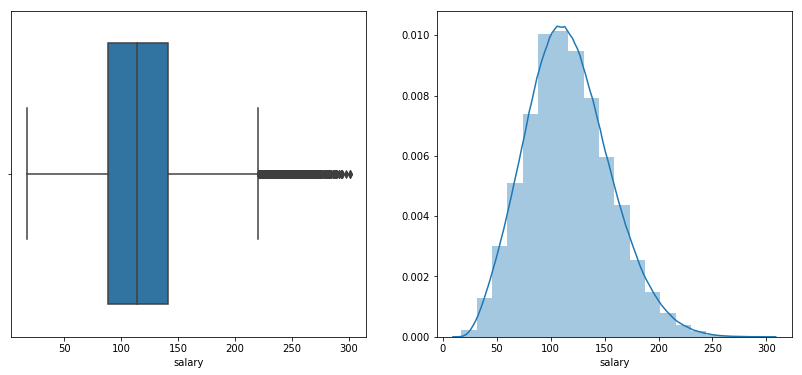

In [19]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(clean_train_df['salary'])
plt.subplot(1,2,2)
sns.distplot(clean_train_df['salary'], bins = 20)
plt.show()

In [25]:
# Examine the outliers below the lower bound- 
clean_train_df[clean_train_df['salary'] < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


__Note - We had spotted five salaries with $0 entry and we dropped those earlier. Looks like we sorted our outliers below the 
lower bound. <br>
Next, let us examine the outliers above__

In [26]:
#Examine potential outliers above the upper bound - 
clean_train_df.loc[clean_train_df['salary'] > 220.5, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [27]:
#Examine the outliers for a particular type(JUNIOR) of column, jobType - 
clean_train_df[(clean_train_df['salary'] > 220.5) & (clean_train_df['jobType'] == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


__The high salary potential outliers seem to be either C-level executives or the Juniors  are in industries such as Oil, Finance etc. who are known to have higher salaries. Hence, we do not drop them as they seem appropriate.__

### Visualize numerical data with salary

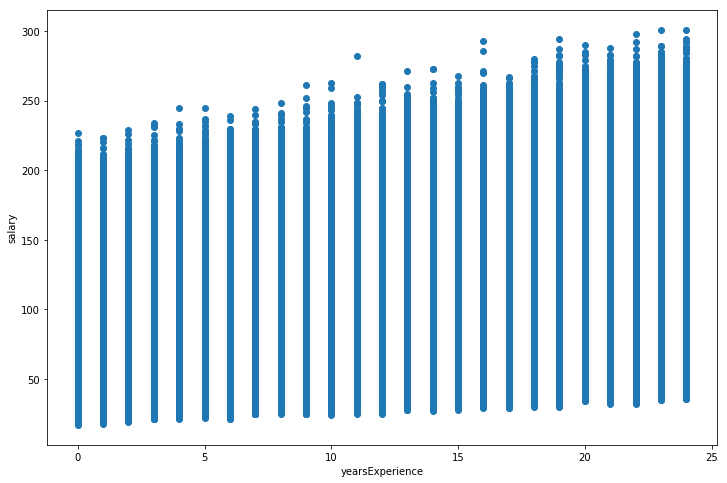

In [28]:
##Calling the function
scatter_data(clean_train_df, 'yearsExperience')

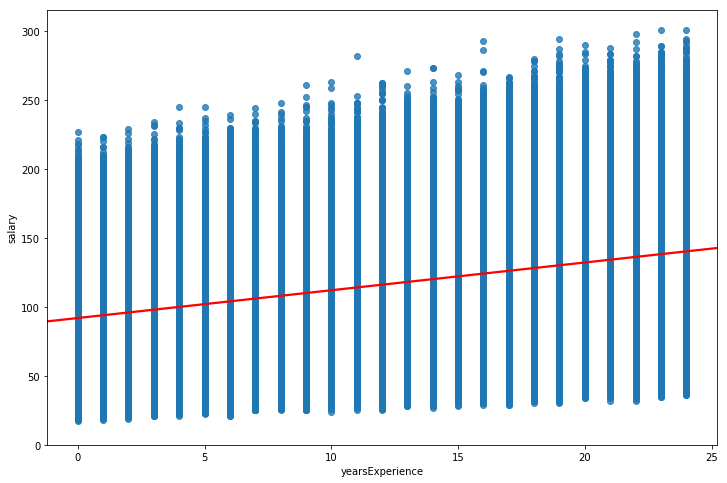

In [29]:
#Fit a regression line to years experience to visualize it as a predictor of salary - 
#Calling the function
reg_data(clean_train_df, 'yearsExperience')

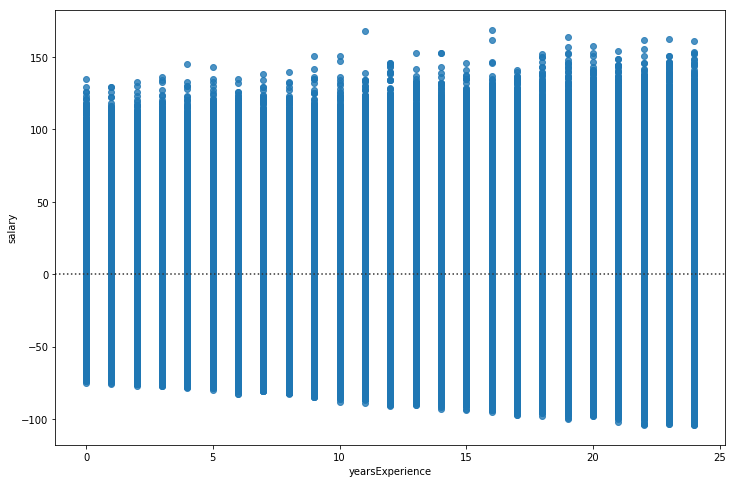

In [29]:
#Variance of yearsExperience-
#Calling the function
res_data(clean_train_df, 'yearsExperience')

__Variance in salary seems to slightly increase with increasing yearsExperience.__

__Data seems to be spread away from the regression line. We can also see a weak positive relationship between yearsExperience 
and salary.__ 

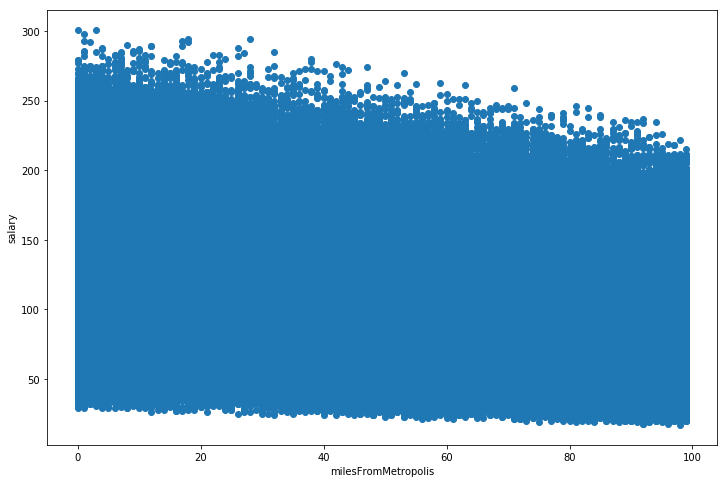

In [30]:
scatter_data(clean_train_df, 'milesFromMetropolis')

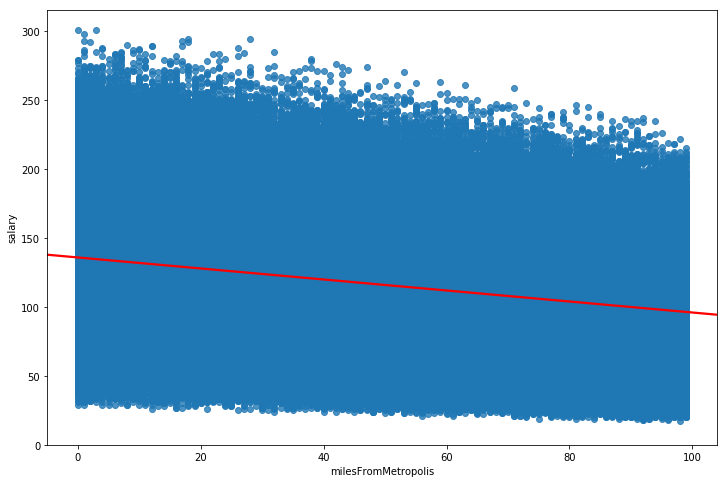

In [31]:
#Fit a regression line to miles from metropolis to visualize it as a predictor of salary -
reg_data(clean_train_df, 'milesFromMetropolis')

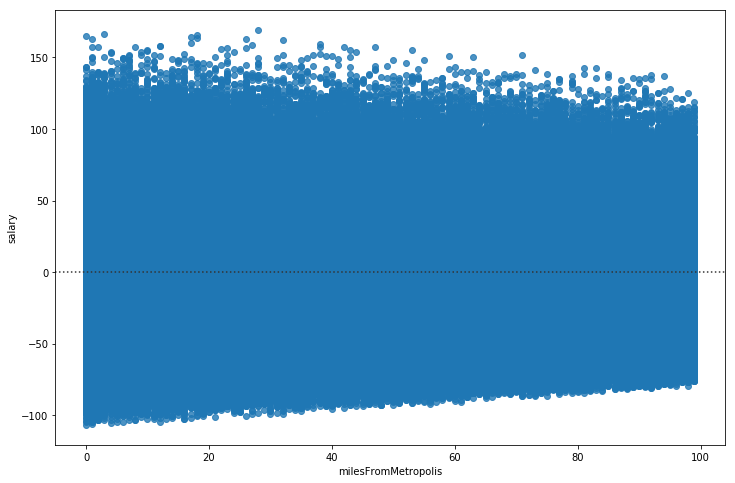

In [32]:
#Variance of milesfrom Metropolis
res_data(clean_train_df, 'milesFromMetropolis')

__Variance in salary seems to slightly decrease with increasing milesFromMetropolis.__ 

__Data is widely spread from the regression line and we can see a weak negative relationship between miles from metropolis and 
salary.__ 

### Relationships with categorical features-

In [33]:
# drop jobId and companyId 
clean_train_df.drop(['jobId'], axis = 1, inplace = True)
clean_train_df.drop(['companyId'], axis = 1, inplace = True)

In [34]:
clean_train_df.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,CFO,MASTERS,MATH,HEALTH,10,83,130
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


__Next we visualize each categorical feature to see which features could be good predictors of salary. We use the violin plot here to see the shape of the distribution curve along with mean and interquartile ranges.__ 

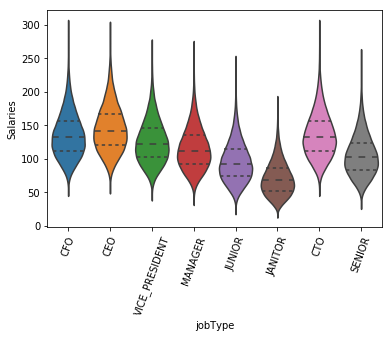

In [35]:
sns.violinplot(x = clean_train_df.jobType, y = clean_train_df['salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries')
plt.show()

__We can see a clear positive correlation between jobType and salary. 
The highest salaries are CEO, followed by CTO and followed by CFO. The lowest salary is for the jobtype Janitor. Distributions appear normal.__

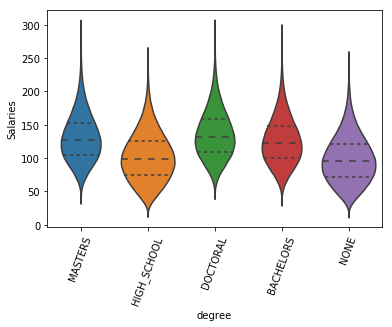

In [36]:
sns.violinplot(x = clean_train_df.degree, y = clean_train_df['salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries')
plt.show()

__We can see that having a college degree corresponds to having higher salaries than high school or no degree. Salary seems to increase with the advance in degrees.__ 

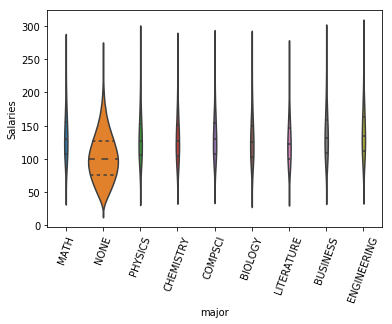

In [37]:
sns.violinplot(x = clean_train_df.major, y = clean_train_df['salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries')
plt.show()

__We can see that people with majors such as engineering, business and math have higher salaries. 
Also, having a major definitely leads to having higher salaries than having no major. Having no major corresponds to people following in the group of no degree and those with only highschool. 
Distributions appear normal.__ 

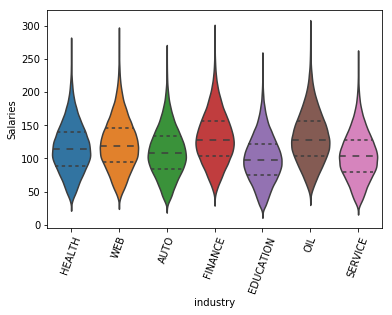

In [38]:
sns.violinplot(x = clean_train_df.industry, y = clean_train_df['salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries')
plt.show()

__Industries such as Oil pay the highest, followed by finance and web. Education industry seems to pay the lowest.__ 

__Now dummy variables will be assigned to categorical data ("one-hot encoding") so it can be used in the prediction models.__ 

In [39]:
## One-hot encode categorical data in clean_train_df dataset
clean_train_df = pd.get_dummies(clean_train_df)

In [40]:
clean_train_df.head()

,yearsExperience,milesFromMetropolis,salary,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,130,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,101,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,137,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,8,17,142,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,163,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


### Correlation between all the features

__Now that numerical values are assigned to all features we can see the correlation between all of them.__

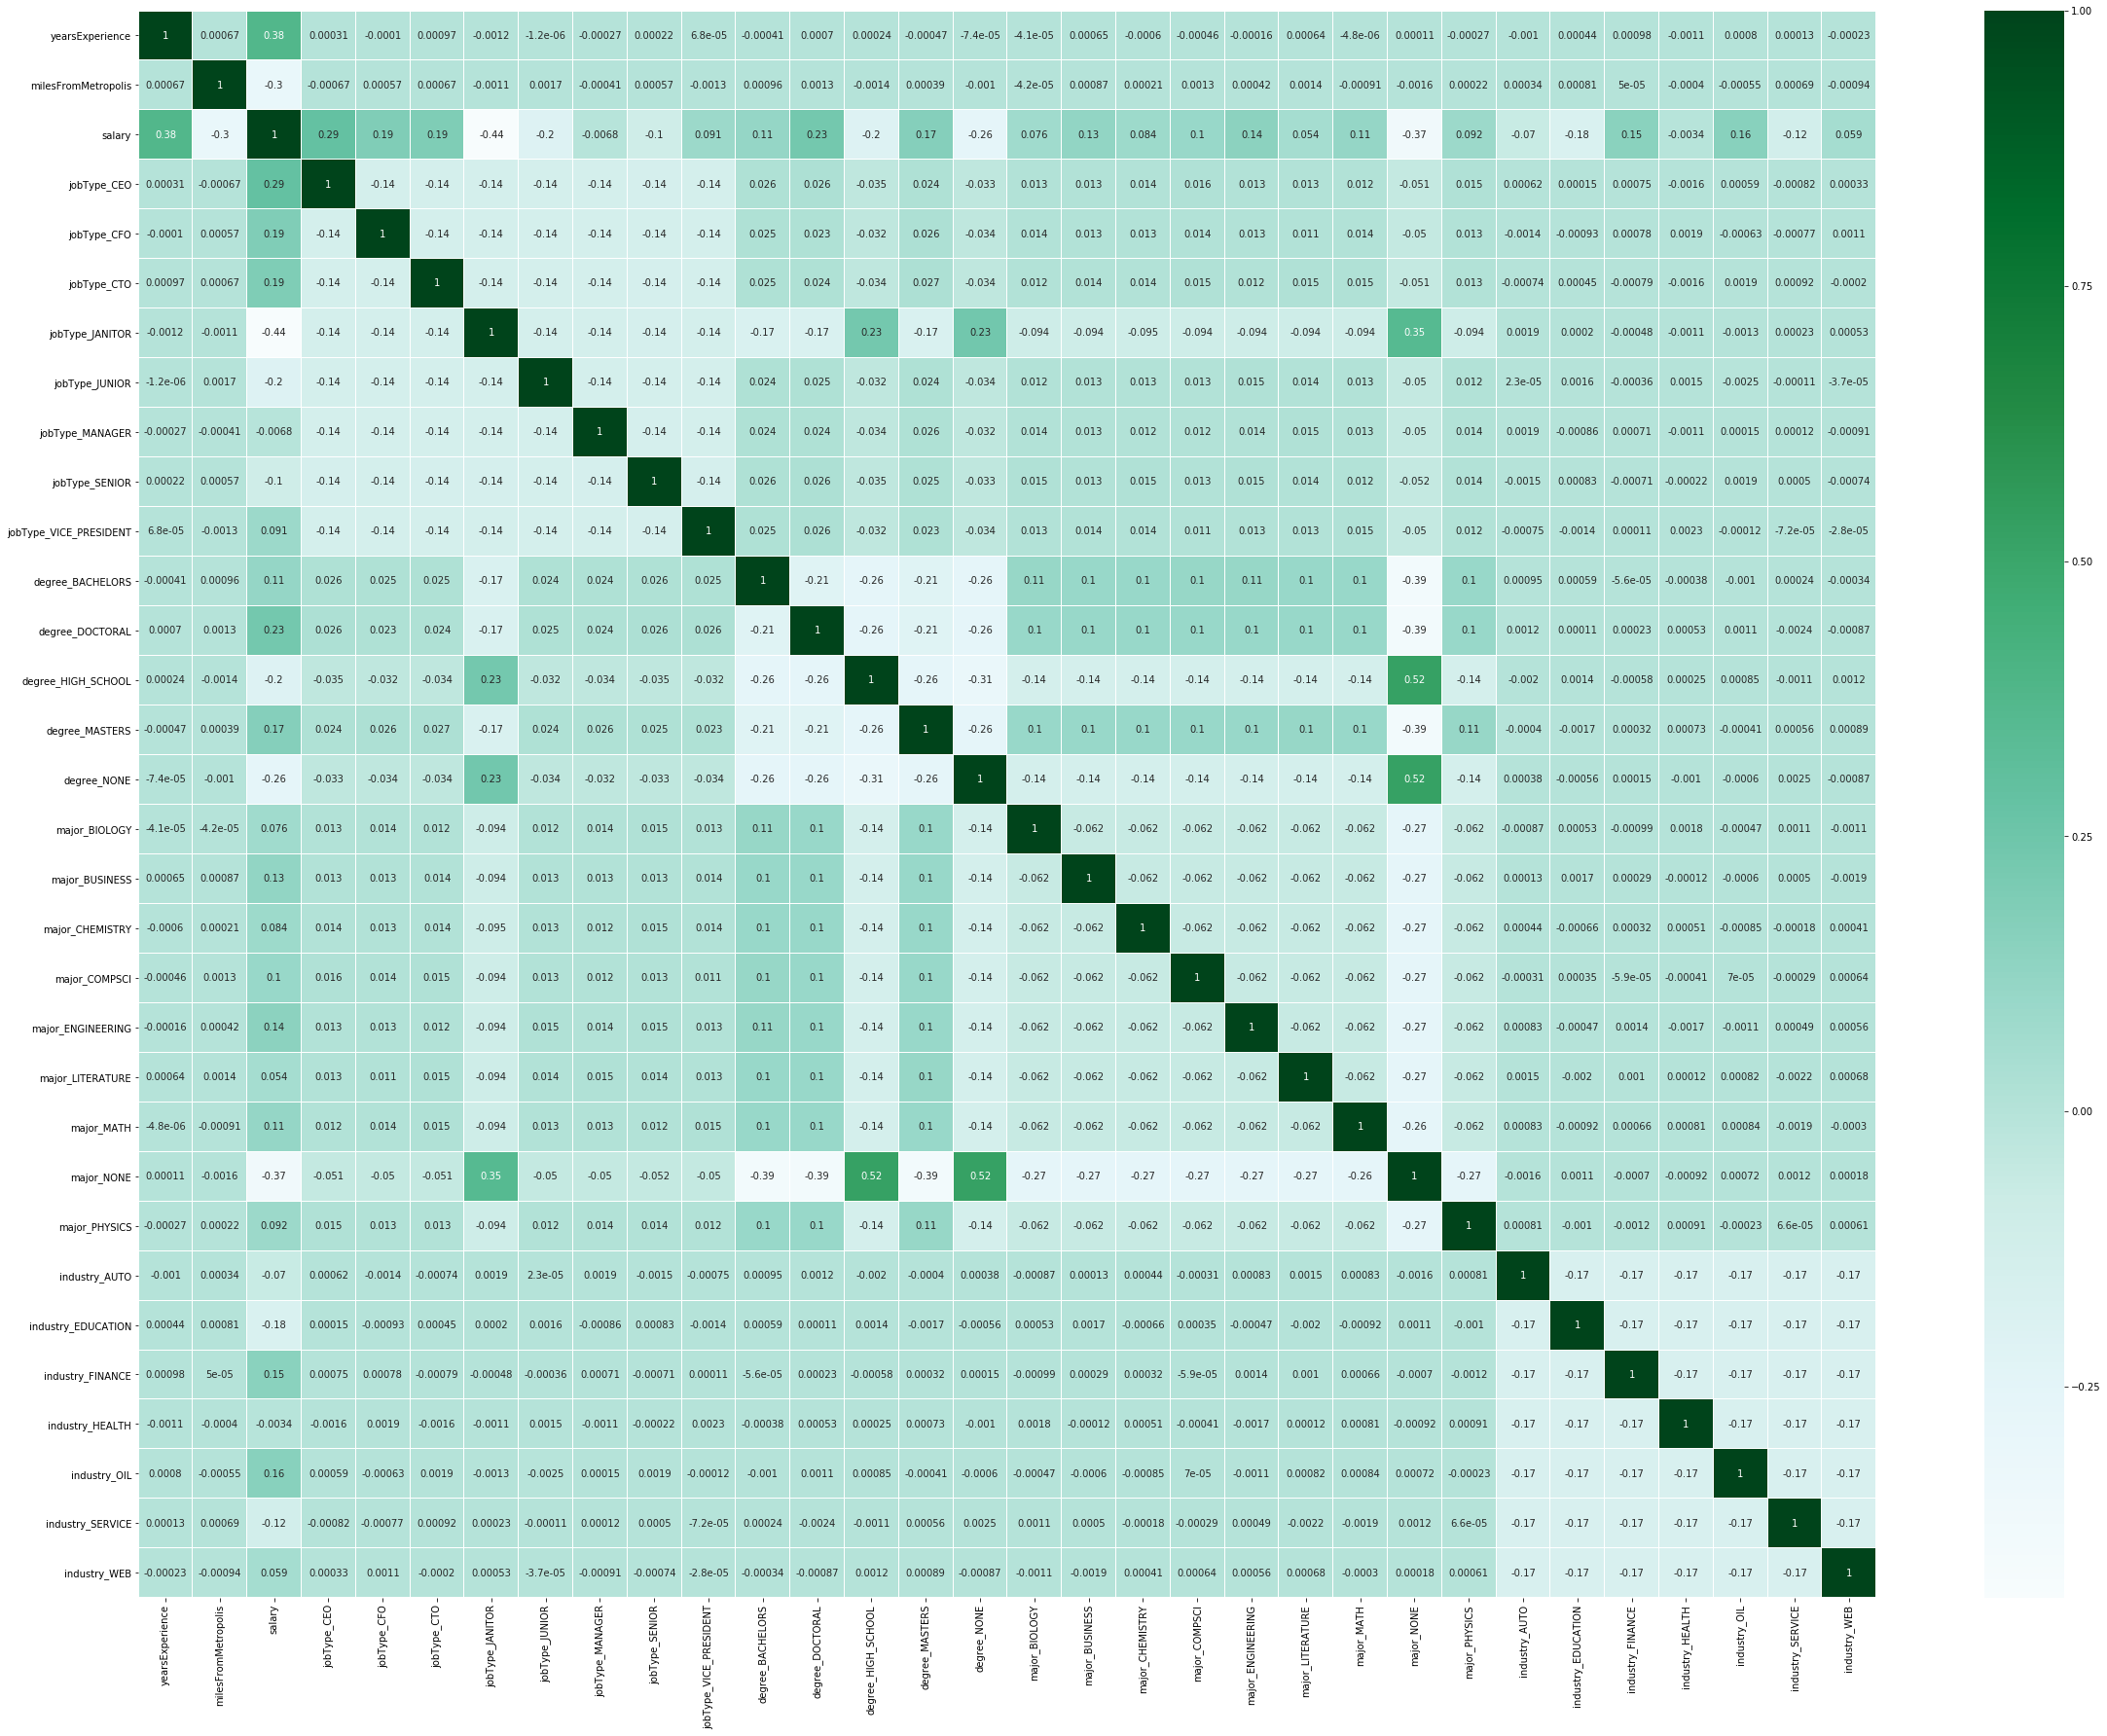

In [41]:
# Plot heatmap of all data with correlation coefficients visible
clean_train_df_corr = clean_train_df.corr()
plt.subplots(figsize=(40,30))
sns.heatmap(clean_train_df_corr, cmap = 'BuGn', linewidth =.005, annot = True)

__yearsExperience has the highest correlation with salary. jobType also seems to be correlated with salary.__ 

__To create a basic training model, two variables will be assigned for the model to use. Twenty percent of the training data will be split into testing data that we can use to test the model with data for which the salaries are already known.__ 

In [47]:
#Split the data and assign 'salary' to 'sal_df' and the rest of the features to 'feat_df'. 
feat_df = clean_train_df[clean_train_df.loc[ :, clean_train_df.columns != 'salary'].columns]
sal_df = clean_train_df['salary']
feat_train, feat_test, sal_train, sal_test = train_test_split(feat_df, sal_df, test_size = 0.2, random_state = 1)

In [50]:
#View inputs and outputs of training model
feat_train.head()

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
583584,17,75,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
465089,14,88,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
686217,12,65,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
176613,8,68,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
249786,3,13,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [51]:
sal_train.head()

583584     90
465089    164
686217     87
176613    126
249786    133
Name: salary, dtype: int64

__We will use linear regression here as salary is a continious variable. With all the data, we see that this is a case of Supervised Regression learning. We will establish the baseline model by appling Linear Regression to feat_train, sal_train.__ 

In [52]:
#Create Linear Regression Object and fit the model
lm = LinearRegression()
lm.fit(feat_train,sal_train)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

__Next, we will view the coefficients of our model -__ 

In [53]:
#View coeff of Linear Regression object 
print(lm.intercept_)
print(lm.coef_)

-39076929678.575096
[ 2.01084731e+00 -3.99647690e-01 -2.29774482e+10 -2.29774482e+10
 -2.29774482e+10 -2.29774483e+10 -2.29774482e+10 -2.29774482e+10
 -2.29774482e+10 -2.29774482e+10  3.98960529e+10  3.98960529e+10
  3.98960529e+10  3.98960529e+10  3.98960529e+10  9.48108049e+09
  9.48108049e+09  9.48108049e+09  9.48108049e+09  9.48108050e+09
  9.48108048e+09  9.48108049e+09  9.48108048e+09  9.48108049e+09
  1.26772446e+10  1.26772446e+10  1.26772446e+10  1.26772446e+10
  1.26772446e+10  1.26772446e+10  1.26772446e+10]


__Now that the baseline model is created, it can predict the salaries. The variable yhat is used to store the predictions using the training data.__ 

In [56]:
#predict salary using training data
yhat = lm.predict(feat_train)

#View first five predictions -
print ('First five predictions:' , yhat[0:5])

First five predictions: [126.75435638 144.07183075  93.90699005 113.80158997 133.27690125]


__Mean squared error (MSE) will be evaluated now along with accuracy and r-squared to evaluate the baseline model's performance and to determine if the subsequent models improve over the established baseline model.__ 

In [59]:
#print MSE - 
print ('Mean Squared Error of our prediction model', mean_squared_error(sal_train, yhat))

Mean Squared Error of our prediction model 384.2694830873358


#### K-Fold Cross Validation

Cross-validation is a procedure used to avoid overfitting and estimate the skill of the model on new data.
The value for k is chosen such that each train/test group of data samples is large enough to be statistically representative of the broader dataset.

In [62]:
# accurace of the baseline model using 5-cross validation method -
score = cross_val_score(lm, feat_train, sal_train, cv = 5)
print ('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))

5-Cross Validation accuracy 0.7433245978365225 0.0005871366766138779


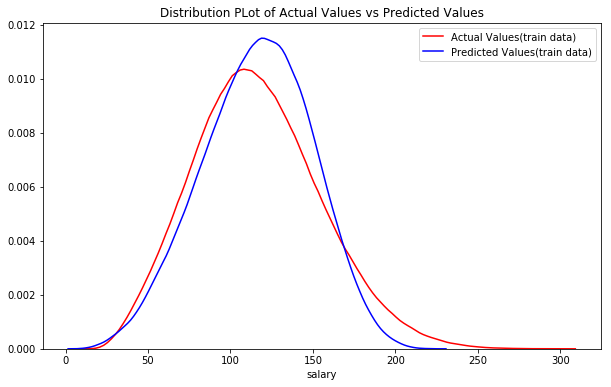

In [63]:
#distribution plot 
#Calling the function
Title = 'Distribution PLot of Actual Values vs Predicted Values'
dis_data(sal_train, yhat, 'Actual Values(train data)', 'Predicted Values(train data)', Title)

__We can see that the actual values and predicted values are not that different. The mean of the predicted values seems higher and the range seems lower.__

__Next, we do the same for the 20% test data to see if the outcome is similar.__ 

In [65]:
#store test set predictions in yhat_test 
yhat_test = lm.predict(feat_test)

#view first five predictions - 
print ('First five predictions(test data)', yhat_test[0:5])

First five predictions(test data) [157.80001068  62.36650848 108.70935822 112.59159088  92.51939392]


In [66]:
#MSE of test data - 
print ('Mean Squared Error of test data ', mean_squared_error(sal_test, yhat_test))

Mean Squared Error of test data  384.8298885966912


__We can see that Mean squared error of the training data and test data is very similar.__

In [67]:
#accuracy of test data using 5-cross validation method - 
score = cross_val_score(lm, feat_test, sal_test, cv = 5)
print ('5-cross validation accuracy(test data)', (np.mean(score)), (np.std(score)))

5-cross validation accuracy(test data) 0.744398497013073 0.0027138842603942315


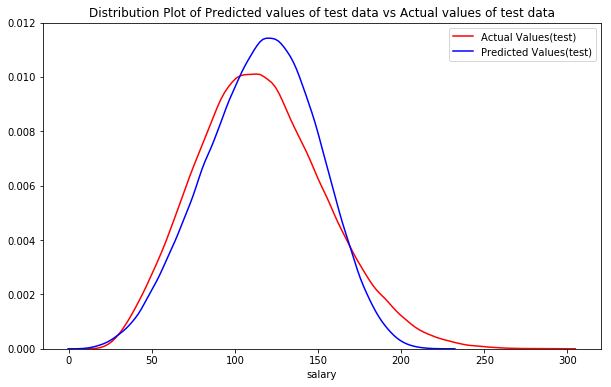

In [68]:
#Distribution plot 
Title = 'Distribution Plot of Predicted values of test data vs Actual values of test data'
dis_data(sal_test, yhat_test, 'Actual Values(test)', 'Predicted Values(test)', title = Title)

__Distribution, accuracy and MSE are not very different when comparing the training data and test data.__ 

__We now try to see if we can reduce the MSE to less than 360.__ 

__Three models that may improve results over the baseline model are -__ 
1. Apply Polynomial Transformation
2. Use Ridge Regression
3. Use Random Forest

   __The shape and features of the training data and testing data will be checked before applying models on them.__

In [69]:
#shape and features -

print ('Number of training samples-', feat_train.shape, '\n with the features-', feat_train.columns)
print ('Number of testing samples-', feat_test.shape, '\n with the features-', feat_test.columns)
print ('Number of training salaries-', sal_train.shape)
print ('Number of testing salaries-', sal_test.shape)

Number of training samples- (799996, 31) 
 with the features- Index(['yearsExperience', 'milesFromMetropolis', 'jobType_CEO', 'jobType_CFO',
       'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 'jobType_MANAGER',
       'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'degree_BACHELORS',
       'degree_DOCTORAL', 'degree_HIGH_SCHOOL', 'degree_MASTERS',
       'degree_NONE', 'major_BIOLOGY', 'major_BUSINESS', 'major_CHEMISTRY',
       'major_COMPSCI', 'major_ENGINEERING', 'major_LITERATURE', 'major_MATH',
       'major_NONE', 'major_PHYSICS', 'industry_AUTO', 'industry_EDUCATION',
       'industry_FINANCE', 'industry_HEALTH', 'industry_OIL',
       'industry_SERVICE', 'industry_WEB'],
      dtype='object')
Number of testing samples- (199999, 31) 
 with the features- Index(['yearsExperience', 'milesFromMetropolis', 'jobType_CEO', 'jobType_CFO',
       'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 'jobType_MANAGER',
       'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'degree_BACHELO

__We will first apply Polynomial Features to already built Linear regression model and see if MSE reduces.__

In [70]:
#Fit and transform the variables with 2nd order polynomial
pr = PolynomialFeatures(2)
feat_train_pr = pr.fit_transform(feat_train)
feat_test_pr = pr.fit_transform(feat_test)
pr

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)

In [71]:
#Create a new model using Polynomial Transformation 
poly = LinearRegression()
poly.fit(feat_train_pr, sal_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [73]:
#make predictions and view first five predictions on train data - 
yhat_pr = poly.predict(feat_train_pr)
print ('First five predictions(train data)-', yhat_pr[0:5])

First five predictions(train data)- [122.80506882 154.60157213  93.93284425 108.47124442 124.48663482]


In [75]:
#Compare first five predicted values vs actual values - 
print ('Predicted Values(train)-', yhat_pr[0:5])
print ('Actual Values(train)-', sal_train[0:5].values)

Predicted Values(train)- [122.80506882 154.60157213  93.93284425 108.47124442 124.48663482]
Actual Values(train)- [ 90 164  87 126 133]


In [76]:
#make predictions and view first five predictions on test data - 
yhat_prtest = poly.predict(feat_test_pr)
print ('First five predictions(test data)-', yhat_prtest[0:5])

First five predictions(test data)- [159.45405945  60.11152849  96.81939039  99.59785494  93.336588  ]


In [77]:
#Compare predicted values of test data and actual values of test data - 
print ('Predicted values(test)-', yhat_prtest[0:5])
print ('Actual values(test)-', sal_test[0:5].values)

Predicted values(test)- [159.45405945  60.11152849  96.81939039  99.59785494  93.336588  ]
Actual values(test)- [186  67  82 104 106]


In [78]:
#print R-squared values of training and testing data - 
print ('R-squared of training data-', poly.score(feat_train_pr, sal_train))
print ('R-squared of testing data-', poly.score(feat_test_pr, sal_test))

R-squared of training data- 0.7638922259746697
R-squared of testing data- 0.7645108022339702


__Minor improvement over base model (0.02)__


In [79]:
#MSE of training and testing data - 
print ('MSE of training data-', mean_squared_error(sal_train, yhat_pr))
print ('MSE of testing data-', mean_squared_error(sal_test, yhat_prtest))

MSE of training data- 353.5146362591453
MSE of testing data- 354.6543978700086


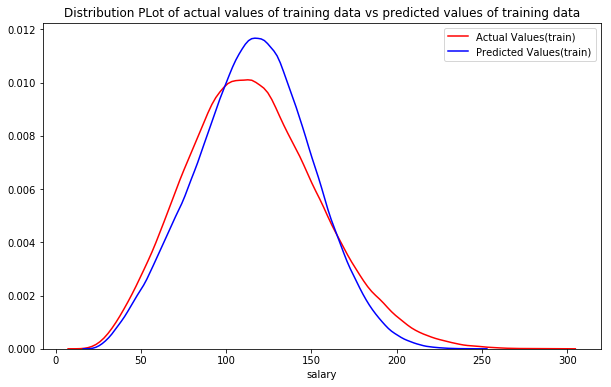

In [80]:
#View distribution plot of actual vs fitted of training data - 
dis_data(sal_test, yhat_pr, 'Actual Values(train)', 'Predicted Values(train)', title = 'Distribution PLot of actual values of training data vs predicted values of training data')

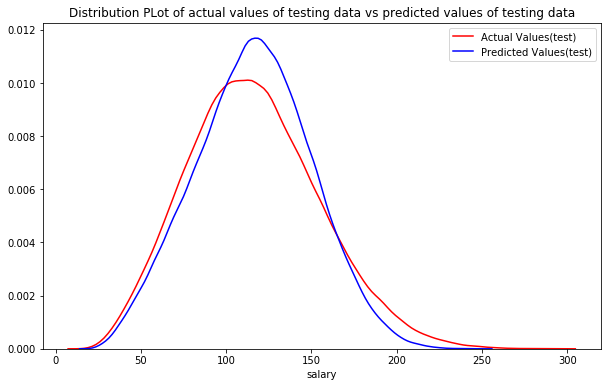

In [81]:
#view distribution plot of actual vs fitted of testing data - 
dis_data(sal_test, yhat_prtest, 'Actual Values(test)', 'Predicted Values(test)', title = 'Distribution PLot of actual values of testing data vs predicted values of testing data')


__Next let us try using Random Forest and Fit a Randorm Forest with random_state = 1 for consistency__

In [82]:
#create a random forest object - 
RF = RandomForestRegressor(n_estimators = 150, n_jobs = 2, max_features = 30)
RF

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=30, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [ ]:
#fit a Random Forest model on training data - 
RF.fit(feat_train, sal_train)

In [ ]:
#make predictions on testing data and print the first five - 
yhat_RF_test = RF.predict(feat_test)
print 'First five predictions-', yhat_RF_test[0:5]

In [110]:
#R-squared and MSE of test data - 
print 'R-squared of test data-', RF.score(feat_test, sal_test)
print 'MSE of test data-', mean_squared_error(sal_test, yhat_RF_test)

R-squared of test data- 0.7069013944725335
MSE of test data- 441.4160413555828


__Linear regression with second order polynomial transformation gave best predictions with MSE of 354 and accuracy of 76%. 
This meets the goal of reducing MSE to below 360.__ 

__Random Forest resulted in worse MSE of approximately 441 and the accuracy of 70%.__ 

## Summary

__Applying second order polynomial transformation to the features gave the most accurate with the least error when using a Linear Regression Model. The result was a mean squared error of 354 with the accuracy of 76%.__ 

__This model can be used as a guide when determining salaries since it results in resonable predictions when given information on years of experience, miles from Metropolis, job type, industry, college degree and major.__ 
